# Homework #9 - _work in progress_

## Problem 1

![two bodies: sliding block and compound pendulum](../images/spring_compound-2_bodies.svg)

For the system shown above, block one slides along the x-axis and is attached via a pin to a link, body 2. The system has the following characteristics, 

- $m^1 = 0.1~kg$
- $k = 40~N/m$
- $F_{spring} = -k(R_x^1-0.2)$
- $l^2 = 1~m$
- $m^2 = 1~kg$



Use the __embedding technique__ to solve for the dynamic response for the system. Separate the generalized coordinates are separated into _dependent_ and _independent_ coordinates as such 

$\mathbf{q} = [\mathbf{q}_d,~\mathbf{q}_i]$.

- $\mathbf{q}_d = [R_y^1,~\theta^1,~R_x^2,~R_y^2]$
- $\mathbf{q}_i = [R_x^1,~\theta^2]$

This distinction creates two second order differential equations, where $n=3\times(\#~bodies)$ and $n_c=number~of~constraints$. The equations of motion are as such

$\mathbf{B^TMB +B^TM\gamma-B^TQ_e = 0}$

where, 
- $\mathbf{B}=\left[\begin{array}{c}-\mathbf{C_{q_d}^{-1}C_{q_i}} \\\bar{I}\end{array}\right]$
- $\gamma = \left[\begin{array}{c}
~\mathbf{-C_{q_d}^{-1}[(C_q\dot{q})_q\dot{q}+2C_{qt}\dot{q}+C_{tt}}] \\
\mathbf{0}\end{array}\right] = \left[\begin{array}{c}
~\mathbf{C_{q_d}^{-1}[Q_d]} \\
\mathbf{0}\end{array}\right]$
- $\mathbf{C_{q_d}}~and~\mathbf{C_{q_i}}$ are the Jacobian of constraints for _dependent_ and _independent_ coordinates, respectively

You will define the following functions:
- `C_sys` the 4 constraint equations for the system
- `Cq_sys` the Jacobian of the system `d C_sys/dq`
- `Bi_link` the array $\mathbf{B}$ that transforms $\delta \mathbf{q_i}$ to $\delta \mathbf{q}$
- `eom_sys` the final equation of motion using the embedding technique

### Define $\mathbf{A}$ and $\mathbf{A}_\theta$

Here, you create two functions to rotate from the body coordinate system at angle $\theta$ to the global coordinate system. The derivate, $\mathbf{A}_\theta$ will be used in the Jacobian and equations of motion. 

In [1]:
def rotA(theta):
    '''This function returns a 2x2 rotation matrix to convert the 
    rotated coordinate to the global coordinate system
    input is angle in radians
        
    Parameters
    ----------
    theta : angle in radians
    
    Returns
    -------
    A : 2x2 array to rotate a coordinate system at angle theta to global x-y
    '''
    A=np.zeros((2,2))
    A=np.array([[np.cos(theta), -np.sin(theta)],
               [np.sin(theta), np.cos(theta)]])
    
    return A

In [2]:
def A_theta(theta):
    '''This function returns a 2x2 rotation matrix derivative 
    input is angle in radians
        
    Parameters
    ----------
    theta : angle in radians
    
    Returns
    -------
    dAda : 2x2 array derivative of `rotA`
    '''
    dAda=np.array([[-np.sin(theta), -np.cos(theta)],
                   [np.cos(theta), -np.sin(theta)]])
    return dAda

Define Jacobian of pin constraint as `Cq_pin`.

In [3]:
def Cq_pin(qi, qj, ui, uj):
    '''Jacobian of a pinned constraint for planar motion

    Parameters
    ----------
    qi : generalized coordinates of the first body, i [Rxi, Ryi, thetai]
    qj : generalized coordinates of the 2nd body, i [Rxj, Ryj, thetaj]
    ui : position of the pin the body-i coordinate system
    uj : position of the pin the body-j coordinate system
        
    Returns
    -------
    Cq_pin : 2 rows x 6 columns Jacobian of pin constraint Cpin
    '''
    
    Cq_1=np.block([np.eye(2), A_theta(qi[2])@ui[:,np.newaxis] ])
    Cq_2=np.block([-np.eye(2), -A_theta(qj[2])@uj[:,np.newaxis] ])
    Cq_pin=np.block([Cq_1, Cq_2])
    return Cq_pin

![](https://learning.oreilly.com/library/view/computational-dynamics-3rd/9780470686157/figs/P605.png)

## Problem 2

Create the system of equations using the augmented formulation. Solve these equations numerically using `solve_ivp` and plot the position and orientation of the links for one revolution of the crankshaft. Assume that $M^2$ = 10N · m, $F^4$ = 15N, $\theta^2$ = 45$^o$, and $\dot{\theta}^2$=150 rad/s.

Present the solution for two different time step sizes (Δt = 0.001 and 0.005 s) and compare the results.

## Appendix Augmented solution for one-bar linkage

![](https://learning.oreilly.com/library/view/computational-dynamics-3rd/9780470686157/figs/0506.png)

In [4]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from numpy import (pi, cos, sin)

In [5]:
def my_ode(t,y,alpha,beta):
    dy=np.zeros(y.shape)
    y1,y2=np.array_split(y,2)
    
    dy[0:len(y2)]=y2
    M=np.diag([1,1,1/12])
    C=np.array([y1[0]-1/2*cos(y1[2]),y1[1]-1/2*sin(y1[2])])
    Ct=np.zeros(C.shape)
    Cq=np.array([[1,0,1/2*sin(y1[2])],[0,1,-1/2*cos(y1[2])]])
    A=np.hstack((M,Cq.T))
    A=np.vstack((A,\
                 np.hstack((Cq,np.zeros((2,2))))))
    
    Qe=np.array([0,-9.81,0])
    Qd=np.array([1/2*y[5]**2*np.cos(y[2]),1/2*y[5]**2*np.sin(y[2])])
    Qd=Qd-2*alpha*(Cq@y2+Ct)-beta**2*C
    #Q=np.array([0,-9.81,0,1/2*y[5]**2*np.cos(y[2]),1/2*y[5]**2*np.sin(y[2])])
    Q=np.hstack((Qe,Qd))
    x=np.linalg.solve(A,Q)
    
    dy[len(y2):]=x[0:len(y2)]
    return dy



In [6]:
t=np.linspace(0,10,1000)
h=t[1]-t[0]
y=solve_ivp(lambda t,y: my_ode(t,y,1/h,np.sqrt(2)/h),\
            y0=[0.5,0,0,0,0,0],t_span=[0,t.max()],t_eval=t)

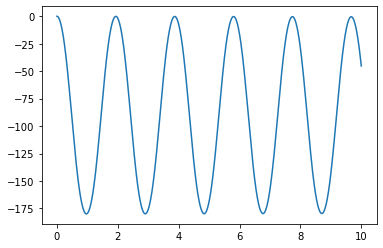

In [7]:
plt.plot(y.t,y.y[2]*180/pi)

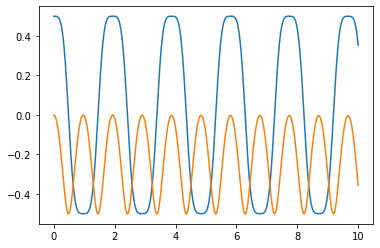

In [8]:
plt.plot(y.t,y.y[0])
plt.plot(y.t,y.y[1])